In [15]:
import sys
sys.path.append('../')

import mmgclip
import torch
import os

from hydra import compose, initialize
from omegaconf import DictConfig, OmegaConf
from attrdict import AttrDict
import torchvision.transforms as transforms
from PIL import Image

torch.cuda.empty_cache() 

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# for auto reload when changes are made in the package
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
with initialize(config_path="../configs"):
    cfg = compose(config_name="train_binary_class_clf")

print(OmegaConf.to_yaml(cfg.base))

patience: 5
seed: 42
features_export_dir: outputs/dataset
export_dir: ${hydra:run.dir}
results_export_dir: ${hydra:run.dir}/results
tensorboard_export_dir: runs/${now:%Y-%m-%d}/${now:%H-%M-%S}



In [3]:
# convert the config dict to a class object
try:
    cfg['dataset']['config']['lists_dataset_path'] = "../data/02_data_lists/data/lists"
    cfg['dataset']['config']['annotated_dataset_path'] = "../data/02_data_T_regions"
    cfg['base']['features_export_dir'] = "../outputs/dataset"
    cfg['base']['export_dir'] = '../outputs/2024-04-24/15-20-56'
    cfg['base']['results_export_dir'] = '../outputs/2024-04-24/15-20-56/results'
    cfg['base']['tensorboard_export_dir'] = '../outputs/...'
    
    mmgconfig = AttrDict(cfg)
    print(mmgconfig)
except Exception as e:
    print("An error occurred:", e)

AttrDict({'checkpoints': {'checkpoints_export_dir': '${hydra:run.dir}/checkpoints', 'checkpoints_file_name': 'model.pth'}, 'base': {'patience': 5, 'seed': 42, 'features_export_dir': '../outputs/dataset', 'export_dir': '../outputs/2024-04-24/15-20-56', 'results_export_dir': '../outputs/2024-04-24/15-20-56/results', 'tensorboard_export_dir': '../outputs/...'}, 'optimizer': {'name': 'adamw', 'config': {'learning_rate': 5e-05, 'weight_decay': 0.0001}}, 'scheduler': {'name': 'cosine', 'config': {'warmup_epochs': 0.1, 'epochs': 30}}, 'experiments': {'config': {'experiment_name': 'classification', 'metrics': ['${dataset.config.enums_class}']}}, 'dataset': {'name': 'ImageLabelDataset', 'config': {'enums_class': 'BenignMalignantDatasetLabels', 'search_col': 'image_label', 'generate_label_prompt_sentence': False, 'generate_label_prompt_report': False, 'base_dataset_path': '/storage/Features/features/png_archive/2D_100micron/0/', 'annotated_dataset_path': '../data/02_data_T_regions', 'lists_datas

In [4]:
clf_dataset = mmgclip.get_dataset(dataset_name=mmgconfig.dataset.name)(config=mmgconfig)
clf_dataset

In [5]:
# train_clf_split, val_clf_split = clf_dataset.random_split(dataset=clf_dataset, split='train')
# val_clf_split, test_clf_split = clf_dataset.random_split(dataset=val_clf_split, split='test')
# print(f"Train split len: ({len(train_clf_split)}), Valid split len ({len(val_clf_split)}), Test split len ({len(test_clf_split)})")

In [6]:
model = mmgclip.model(config=mmgconfig)
model.load_state_dict(torch.load('../outputs/2024-04-29/11-05-48/checkpoints/model.pth')['model_state_dict'])
model.eval()

clf   = mmgclip.PromptClassifier(model=model)

In [7]:
# test_sample = clf_dataset[6]
test_sample = clf_dataset[9]
print(test_sample['prompt_labels'])
print(test_sample['image_description'])
print(test_sample)

{'HasMassLabels': 'mass', 'MassShapeLabels': 'oval', 'MassMarginLabels': 'circumscribed', 'BenignMalignantDatasetLabels': 'benign', 'HasArchDistortion': 'no architectural distortion', 'HasCalcification': 'negative'}
benign
{'image_features': tensor([[[[0.8987]],

         [[1.4821]],

         [[0.8805]],

         [[1.3439]],

         [[0.5651]],

         [[0.9968]],

         [[0.9588]],

         [[1.0235]],

         [[1.2076]],

         [[0.6489]],

         [[0.7574]],

         [[0.7225]],

         [[0.8286]],

         [[0.9313]],

         [[1.2748]],

         [[0.9464]],

         [[1.1539]],

         [[1.2058]],

         [[1.0310]],

         [[1.1696]],

         [[1.3654]],

         [[1.0370]],

         [[0.7737]],

         [[1.6307]],

         [[0.7647]],

         [[1.4370]],

         [[1.3487]],

         [[1.1137]],

         [[1.2727]],

         [[1.2838]],

         [[0.7719]],

         [[0.7124]],

         [[1.5523]],

         [[0.9332]],

         [

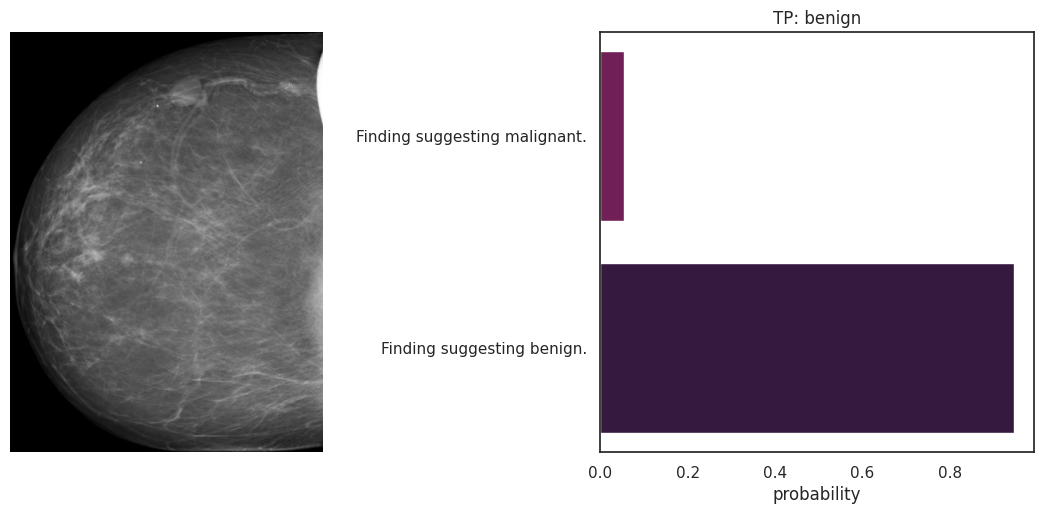

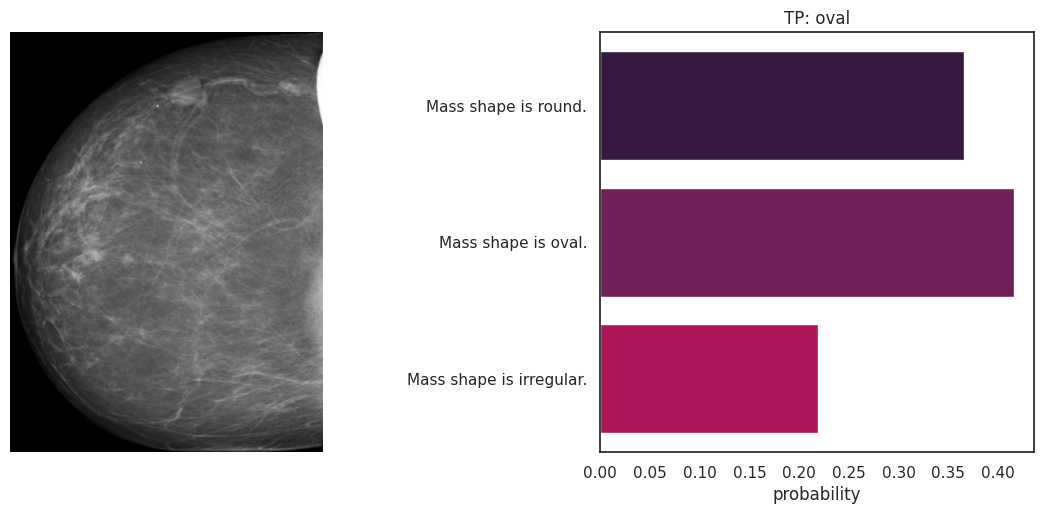

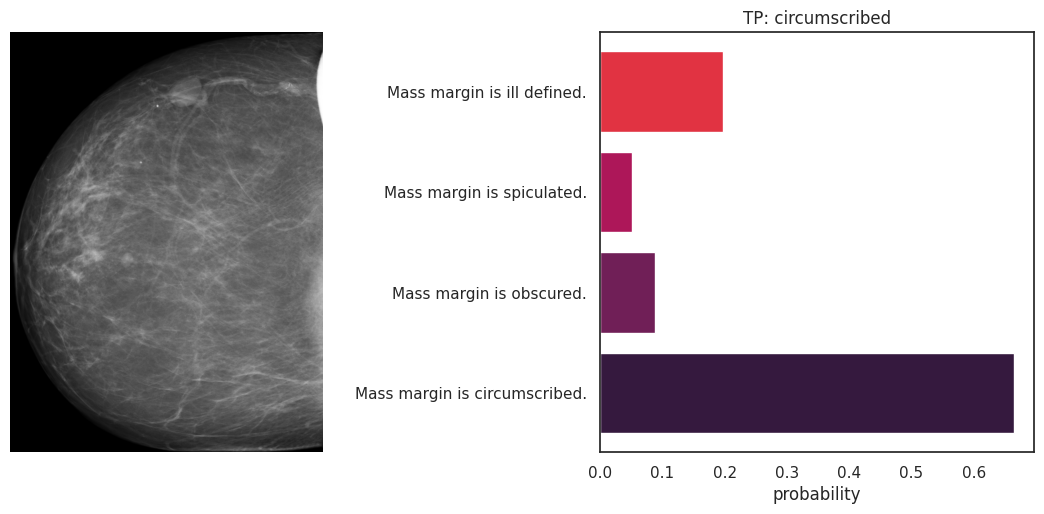

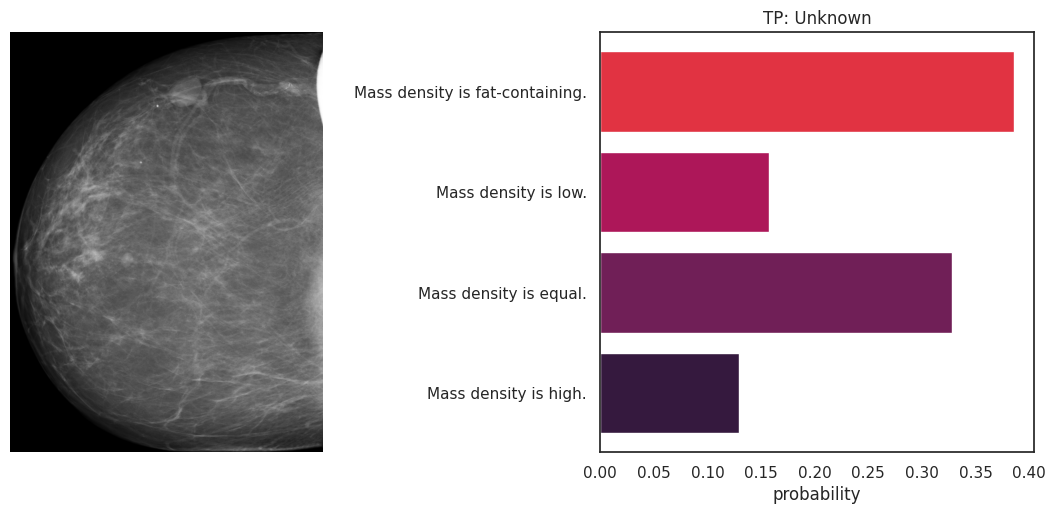

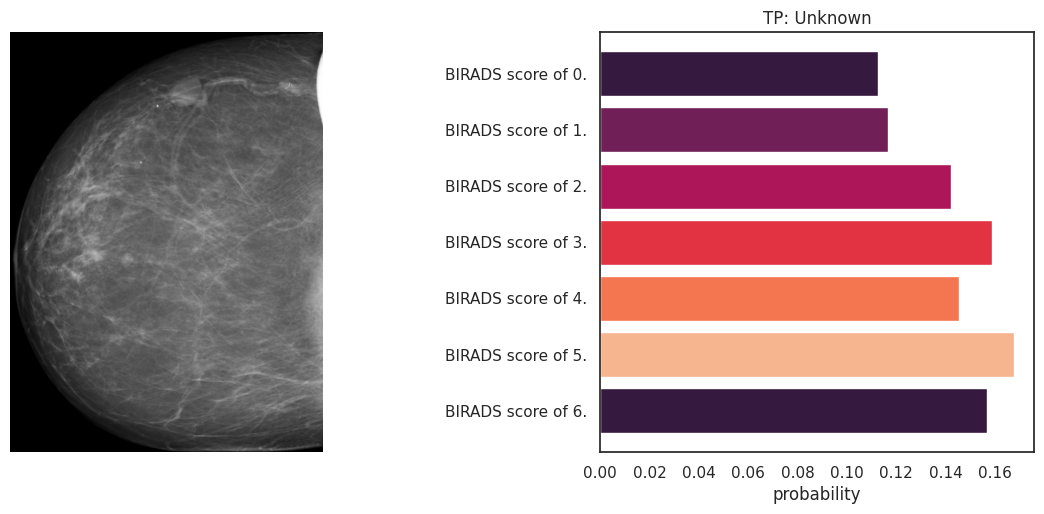

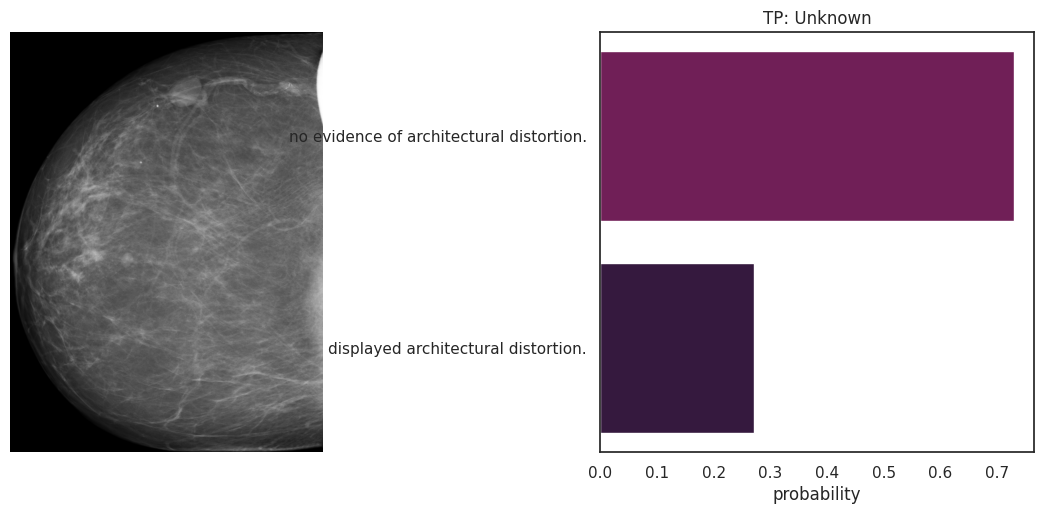

{'classes_similarities': tensor([[0.9458, 0.0542]], device='cuda:0'), 'similarities_argmax': 0, 'class_list': ['Finding suggesting benign.', 'Finding suggesting malignant.']}
{'classes_similarities': tensor([[0.3657, 0.4156, 0.2187]], device='cuda:0'), 'similarities_argmax': 1, 'class_list': ['Mass shape is round.', 'Mass shape is oval.', 'Mass shape is irregular.']}
{'classes_similarities': tensor([[0.6638, 0.0879, 0.0516, 0.1968]], device='cuda:0'), 'similarities_argmax': 0, 'class_list': ['Mass margin is circumscribed.', 'Mass margin is obscured.', 'Mass margin is spiculated.', 'Mass margin is ill defined.']}
{'classes_similarities': tensor([[0.1294, 0.3278, 0.1574, 0.3855]], device='cuda:0'), 'similarities_argmax': 3, 'class_list': ['Mass density is high.', 'Mass density is equal.', 'Mass density is low.', 'Mass density is fat-containing.']}
{'classes_similarities': tensor([[0.1125, 0.1167, 0.1421, 0.1589, 0.1455, 0.1676, 0.1567]],
       device='cuda:0'), 'similarities_argmax': 5,

In [13]:
classifiaction_result_type = clf(
    image_features = test_sample['image_features'],
    class_list = ["Finding suggesting benign.", "Finding suggesting malignant."],
    visualize = True,
    image_id = test_sample['image_id'],
    ground_truth = test_sample['prompt_labels']['BenignMalignantDatasetLabels']
)
    
classifiaction_result_shape = clf(
    image_features = test_sample['image_features'],
    class_list = ["Mass shape is round.", "Mass shape is oval.", "Mass shape is irregular."],
    visualize = True,
    image_id = test_sample['image_id'],
    ground_truth = test_sample['prompt_labels']['MassShapeLabels']
)

classifiaction_result_margin = clf(
    image_features = test_sample['image_features'],
    class_list = ["Mass margin is circumscribed.", "Mass margin is obscured.", "Mass margin is spiculated.", "Mass margin is ill defined."],
    visualize = True,
    image_id = test_sample['image_id'],
    ground_truth = test_sample['prompt_labels']['MassMarginLabels']
)

classifiaction_result_density = clf(
    image_features = test_sample['image_features'],
    class_list = ["Mass density is high.", "Mass density is equal.", "Mass density is low.", "Mass density is fat-containing."],
    visualize = True,
    image_id = test_sample['image_id'],
    ground_truth = "Unknown"
)

classifiaction_result_birads = clf(
    image_features = test_sample['image_features'],
    class_list = ["BIRADS score of 0.", "BIRADS score of 1.", "BIRADS score of 2.", "BIRADS score of 3.", "BIRADS score of 4.", "BIRADS score of 5.", "BIRADS score of 6.",],
    visualize = True,
    image_id = test_sample['image_id'],
    ground_truth = "Unknown"
)

classifiaction_result_arch_dist = clf(
    image_features = test_sample['image_features'],
    class_list = ["displayed architectural distortion.", "no evidence of architectural distortion."],
    visualize = True,
    image_id = test_sample['image_id'],
    ground_truth = "Unknown"
)

print(classifiaction_result_type)
print(classifiaction_result_shape)
print(classifiaction_result_margin)
print(classifiaction_result_density)
print(classifiaction_result_birads)
print(classifiaction_result_arch_dist)

In [16]:

transform = transforms.Compose([transforms.ToTensor()])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_encoder  = torch.jit.load("../mmgclip/models/image_encoders/clf_convnext_tiny/classifier_convnext_tiny_16bits_images.pt")
image_encoder = image_encoder.to(device)
image_encoder.eval()


RecursiveScriptModule(
  original_name=ConvNeXt_spm
  (features): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(
      original_name=Conv2dNormActivation
      (0): RecursiveScriptModule(original_name=Conv2d)
      (1): RecursiveScriptModule(original_name=LayerNorm2d)
    )
    (1): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(
        original_name=CNBlock
        (block): RecursiveScriptModule(
          original_name=Sequential
          (0): RecursiveScriptModule(original_name=Conv2d)
          (1): RecursiveScriptModule(original_name=Permute)
          (2): RecursiveScriptModule(original_name=LayerNorm)
          (3): RecursiveScriptModule(original_name=Linear)
          (4): RecursiveScriptModule(original_name=GELU)
          (5): RecursiveScriptModule(original_name=Linear)
          (6): RecursiveScriptModule(original_name=Permute)
        )
        (stochastic_depth): RecursiveScriptModule(original_n

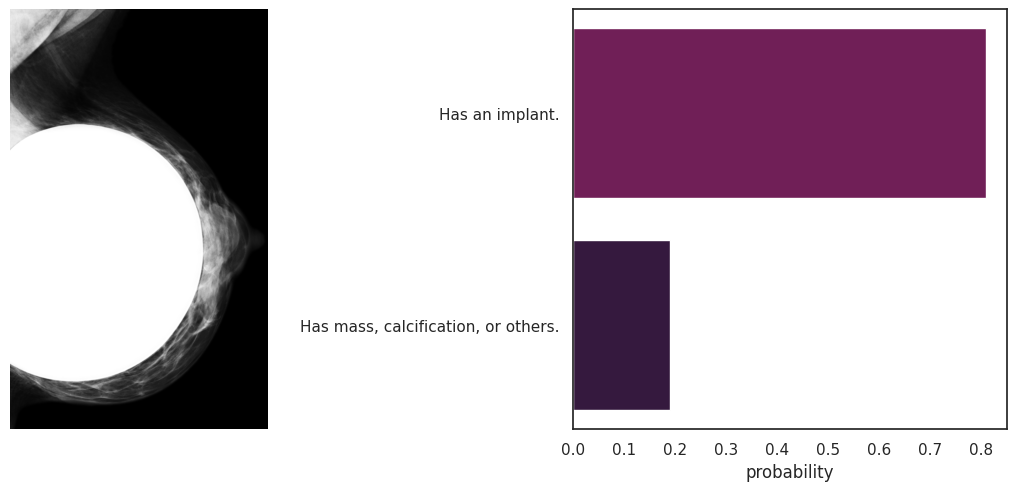

In [17]:

image_raw = Image.open('/storage/Features/features/png_archive/2D_100micron/0/02/02002474/st02/p0200247402ml.png')
image_tensor = transform(image_raw).to(device)

# Dicom images in 16bits, while pngs are 8 bits to save space
image_tensor = 65535 * image_tensor
image_tensor = image_tensor.unsqueeze(0)

# Apply Forward pass in stages
image_tensor_norm = (image_tensor - 32767.5) / 32767.5
feature_map = image_encoder.features((image_tensor_norm))
features = image_encoder.avgpool(feature_map)

clf_implants = clf(
    image_features = features,
    class_list = ["Has mass, calcification, or others.", "Has an implant."],
    visualize = True,
    image_id = 'p0200247402ml',
    # ground_truth = "Unknown"
)
